In [3]:
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pickle
from tensorflow.keras.layers import Input, Add, Activation, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import torch
import tensorflow as tf

# Check device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device (PyTorch):", device)

# Check device for TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available (TensorFlow)")
else:
    print("GPU is not available (TensorFlow)")

Using device (PyTorch): cuda
GPU is available (TensorFlow)


In [2]:
def load_datasets():
    train = pd.read_table("../datasets/ritxt/train.txt", delimiter=";", header=None)
    val = pd.read_table("../datasets/ritxt/val.txt", delimiter=";", header=None)
    test = pd.read_table("../datasets/ritxt/test.txt", delimiter=";", header=None)
    generated = pd.read_table("../datasets/ritxt/generated.txt", delimiter=";", header=None)

    train.columns = ["Text", "Emotion"]
    val.columns = ["Text", "Emotion"]
    test.columns = ["Text", "Emotion"]
    generated.columns = ["Text", "Emotion"]

    data = pd.concat([train, val, test, generated], ignore_index=True)
    data.columns = ["text", "label"]
    emotion_counts = data['label'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, hue=emotion_counts.index, palette='viridis', legend=False)
    plt.title('Distribution of Emotions', fontsize=16)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Records', fontsize=12)
    plt.show()

    return train, val, test, data

In [3]:
def preprocess_text(text, lemmatizer=None):
    review = re.sub("[^a-zA-Z]", " ", text)
    review = review.lower()
    review = review.split()
    stop_words = set(stopwords.words("english"))

    if lemmatizer:
        review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    else:
        review = [PorterStemmer().stem(word) for word in review if word not in stop_words]

    return " ".join(review)

In [4]:
def filter_low_frequency_words(train, val, test, threshold=2):
    all_text = " ".join(train["text"].tolist() + val["text"].tolist() + test["text"].tolist())
    word_freq = Counter(all_text.split())

    for df in [train, val, test]:
        df["text"] = df["text"].apply(
            lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold])
        )
    return train, val, test

In [5]:
def prepare_data(train, val, test, tokenizer, max_len=100):
    tokenizer.fit_on_texts(train["text"])

    X_train = tokenizer.texts_to_sequences(train["text"])
    X_val = tokenizer.texts_to_sequences(val["text"])
    X_test = tokenizer.texts_to_sequences(test["text"])

    X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
    X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

    y_train = np.array(train["N_label"])
    y_val = np.array(val["N_label"])
    y_test = np.array(test["N_label"])

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_and_compile_model(vocab_size, embedding_dim, max_len, num_classes):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, filters=128)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, filters=128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


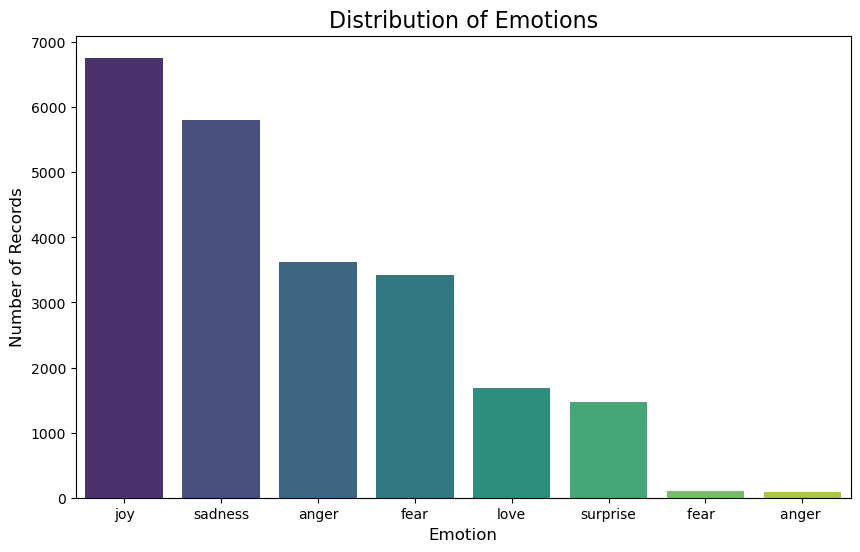

Epoch 1/10
500/500 [==============================] - 8s 6ms/step - loss: 1.1898 - accuracy: 0.4911 - val_loss: 0.6633 - val_accuracy: 0.7605
Epoch 2/10
500/500 [==============================] - 3s 5ms/step - loss: 0.4657 - accuracy: 0.8427 - val_loss: 0.3276 - val_accuracy: 0.8955
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.2153 - accuracy: 0.9252 - val_loss: 0.3029 - val_accuracy: 0.9075
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1497 - accuracy: 0.9448 - val_loss: 0.2826 - val_accuracy: 0.9120
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1091 - accuracy: 0.9609 - val_loss: 0.2860 - val_accuracy: 0.9170
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0889 - accuracy: 0.9682 - val_loss: 0.4323 - val_accuracy: 0.9155
Epoch 7/10
500/500 [==============================] - 3s 7ms/step - loss: 0.0823 - accuracy: 0.9719 - val_loss: 0.3531 - val_accuracy: 0.9180
Epoch 

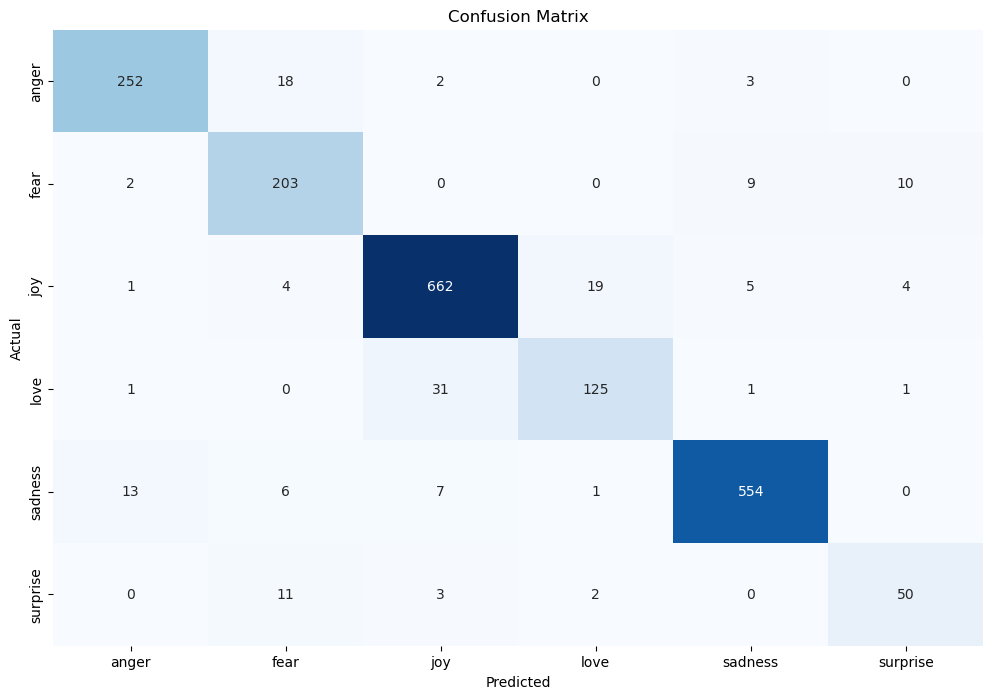

              precision    recall  f1-score   support

       anger       0.94      0.92      0.93       275
        fear       0.84      0.91      0.87       224
         joy       0.94      0.95      0.95       695
        love       0.85      0.79      0.82       159
     sadness       0.97      0.95      0.96       581
    surprise       0.77      0.76      0.76        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



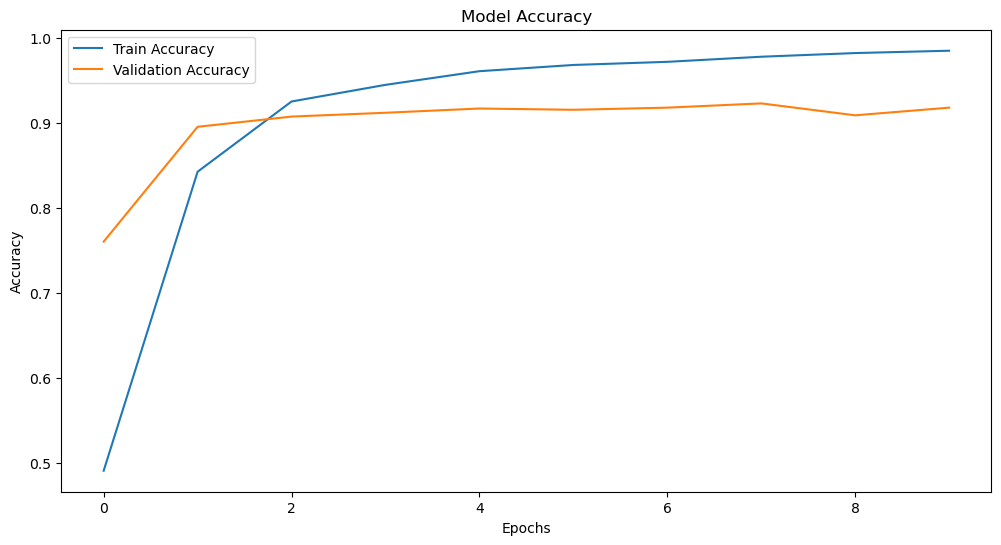

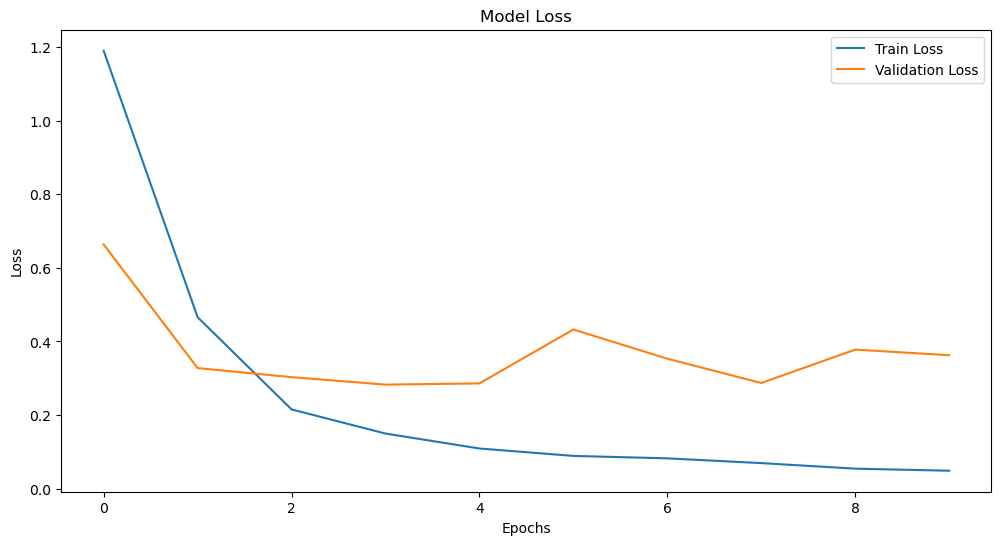

63/63 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.9230
Test Accuracy: 92.30%


In [8]:
def main():
    train, val, test, data = load_datasets()

    lemmatizer = WordNetLemmatizer()
    train["text"] = train["Text"].apply(lambda x: preprocess_text(x, lemmatizer))
    val["text"] = val["Text"].apply(lambda x: preprocess_text(x, lemmatizer))
    test["text"] = test["Text"].apply(lambda x: preprocess_text(x, lemmatizer))

    train, val, test = filter_low_frequency_words(train, val, test)

    label_encoder = preprocessing.LabelEncoder()
    train["N_label"] = label_encoder.fit_transform(train["Emotion"])
    val["N_label"] = label_encoder.transform(val["Emotion"])
    test["N_label"] = label_encoder.transform(test["Emotion"])

    max_len = 100
    tokenizer = Tokenizer(num_words=5000)
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(train, val, test, tokenizer, max_len)

    model = build_and_compile_model(vocab_size=5000, embedding_dim=128, max_len=max_len, num_classes=len(label_encoder.classes_))

    train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder)

    model.save("../exported_files/cnn_with_resnet.h5")
    with open("../exported_files/cnn_with_resnet_tokenizer.pkl", "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("../exported_files/cnn_with_resnet_label_encoder.pkl", "wb") as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


if __name__ == "__main__":
    main()
